[View in Colaboratory](https://colab.research.google.com/github/vocong25/Catchy/blob/master/FashionEmbedding.ipynb)

In [2]:
# https://drive.google.com/open?id=11xUCISuIpz07UMJSuMcivwMNLrpubTmX
!ls

datalab


In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
%matplotlib inline
from keras.models import load_model
from keras.applications import vgg19, vgg16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, AveragePooling2D 
from keras.layers import Flatten, BatchNormalization, Convolution2D, Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import SGD
from keras import Model
import keras

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import cv2
import pickle
import matplotlib as mpl
import glob
mpl.rcParams['figure.figsize'] = (10, 10)

Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id': '11xUCISuIpz07UMJSuMcivwMNLrpubTmX'})

In [0]:
downloaded.GetContentFile('img.zip')

In [0]:
!unzip -P mmlab_DeepFashion_inshop img.zip

# **This is for categorical data**

In [0]:
def categorize_labels(file_path):
  NUM_LABELS = 18
  STYLES = ['Denim', 'Jackets_Vests', 'Pants', 'Shirts_Polos', 'Shorts', 
            'Suiting', 'Sweaters', 'Sweatshirts_Hoodies', 'Tees_Tanks', 
            'Blouses_Shirts', 'Cardigans', 'Dresses','Graphic_Tees',
            'Jackets_Coats', 'Leggings', 'Rompers_Jumpsuits','Skirts']
  
  
  labels = np.zeros((1, NUM_LABELS))  # 0:     gender
                                      # 1-18 : style

  # file_path: /content/img/MEN/Denim/id_00002243/01_1_front.jpg 
  style = file_path.split('/')[-3]
  gender = file_path.split('/')[-4]
  
  if gender == 'WOMEN':
    labels[0, 0] = 1   # Female
  else:
    labels[0, 0] = 0   # Male

  for idx, style_in_arr in enumerate(STYLES):
    if style == style_in_arr:
      labels[0, idx+1] = 1
  labels = np.asarray(labels).reshape(-1)
  return labels

# Test
print(categorize_labels('img/MEN/Denim/id_00000938/05_2_side.jpg'))
print('-------------------------------------------------------------------')
print(categorize_labels('img/WOMEN/Blouses_Shirts/id_00002452/02_7_additional.jpg'))

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------------------------------------------
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Analyze Dataset

In [0]:
# Split Training and Testing data
# file_path: /content/img/MEN/Denim/id_00002243/01_1_front.jpg 
image_paths = glob.glob('/content/img/*/*/*/*.jpg')
print('Number of Images: {}'.format(len(image_paths)))

Number of Images: 52712


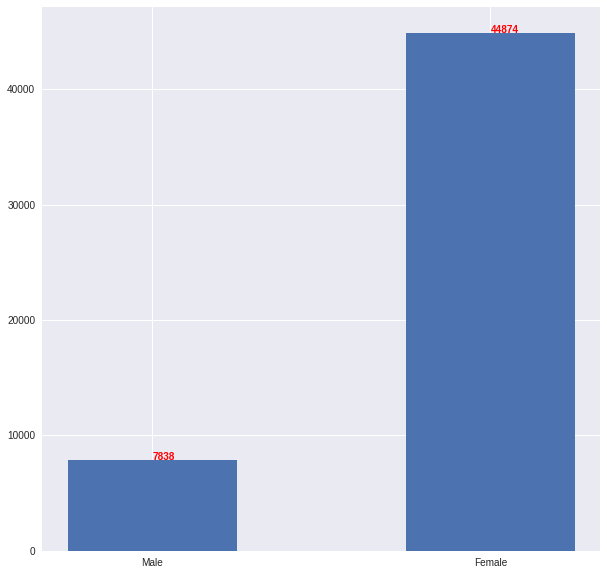

In [0]:
def count_gender_factor(image_paths):
  num_female_outfits = 0
  num_male_outfits = 0

  for image_path in image_paths:
    gender = np.array(categorize_labels(image_path))[0]
    if gender == 1:
      num_female_outfits += 1
    else:
      num_male_outfits += 1

  width = 1/2
  plt.bar(range(2), [num_male_outfits, num_female_outfits], width)
  plt.xticks(range(2), ['Male', 'Female'])
  # for i, v in enumerate(y):
  plt.text(0, num_male_outfits, str(num_male_outfits), color='red', fontweight='bold')
  plt.text(1, num_female_outfits, str(num_female_outfits), color='red', fontweight='bold')
  
count_gender_factor(image_paths)

In [0]:
train_paths, test_paths = train_test_split(image_paths, random_state=0, test_size=0.02)
print('Number of train_paths: {}'.format(len(train_paths)))
print('Number of test_paths: {}'.format(len(test_paths)))

Number of train_paths: 51657
Number of test_paths: 1055


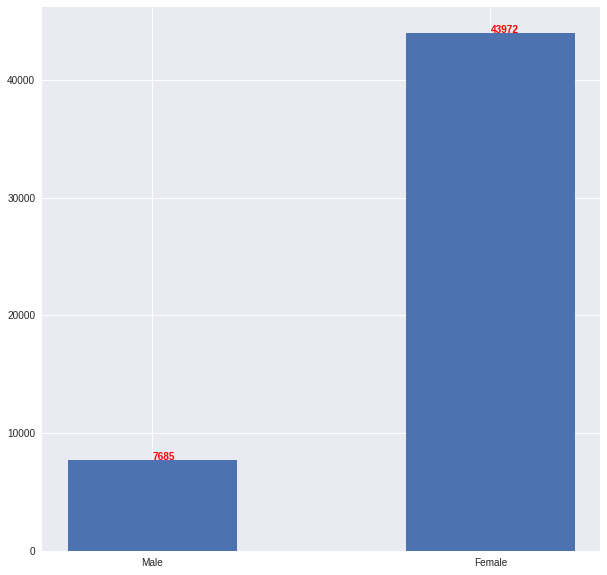

In [0]:
count_gender_factor(train_paths)

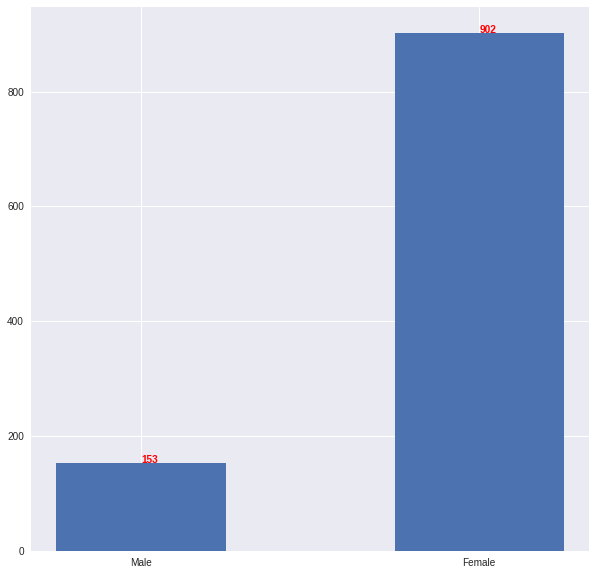

In [0]:
count_gender_factor(test_paths)

In [0]:
def count_style_factor(image_paths):
  STYLES = ['Denim', 'Jackets_Vests', 'Pants', 'Shirts_Polos', 'Shorts', 
            'Suiting', 'Sweaters', 'Sweatshirts_Hoodies', 'Tees_Tanks', 
            'Blouses_Shirts', 'Cardigans', 'Dresses','Graphic_Tees',
            'Jackets_Coats', 'Leggings', 'Rompers_Jumpsuits','Skirts']
  
  count = np.zeros((len(STYLES), 1))  # 0:     gender
                                      # 1-18 : style

  # file_path: /content/img/MEN/Denim/id_00002243/01_1_front.jpg 
  for image_path in image_paths:
    style = image_path.split('/')[-3]
  #   gender = file_path.split('/')[-4]

    for idx, style_in_arr in enumerate(STYLES):
      if style == style_in_arr:
        count[idx, 0] += 1

  count_arr = np.asarray(count).reshape(-1)
  print(count_arr)
  width = 1/2
  plt.barh(range(len(STYLES)), count_arr, width)
  plt.yticks(range(len(STYLES)), STYLES)
  
  for i, v in enumerate(count_arr):
    plt.text(v + 0.2*np.min(count_arr), i - width/4, str(v), color='red', fontweight='bold')
#   plt.text(1, num_female_outfits, str(num_female_outfits), color='red', fontweight='bold')



[  804.   424.  2821.   722.  4476.    39.  3641.  1631. 14487.  7964.
  1436.  6999.  1297.  1895.   335.  1696.  2045.]


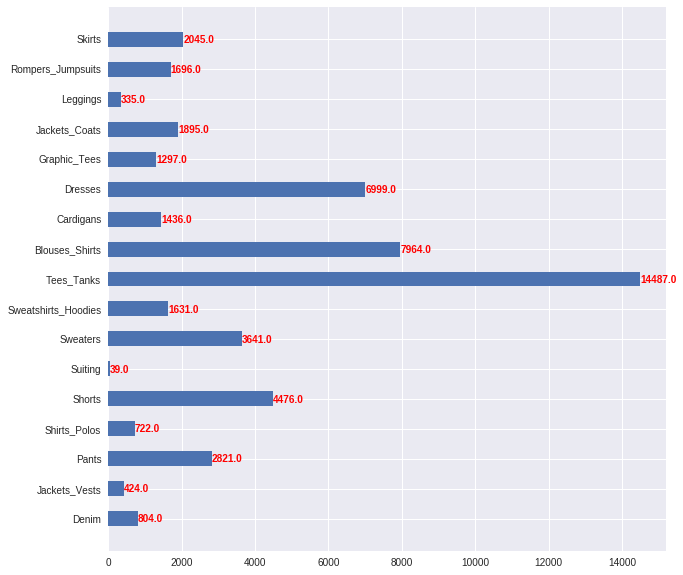

In [0]:
count_style_factor(image_paths)

[  789.   409.  2760.   705.  4380.    38.  3567.  1592. 14218.  7782.
  1414.  6863.  1272.  1866.   329.  1665.  2008.]


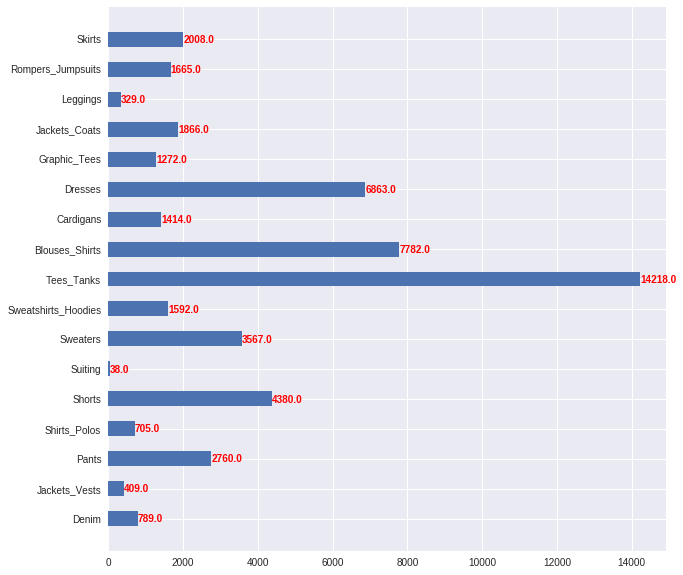

In [0]:
count_style_factor(train_paths)

[ 15.  15.  61.  17.  96.   1.  74.  39. 269. 182.  22. 136.  25.  29.
   6.  31.  37.]


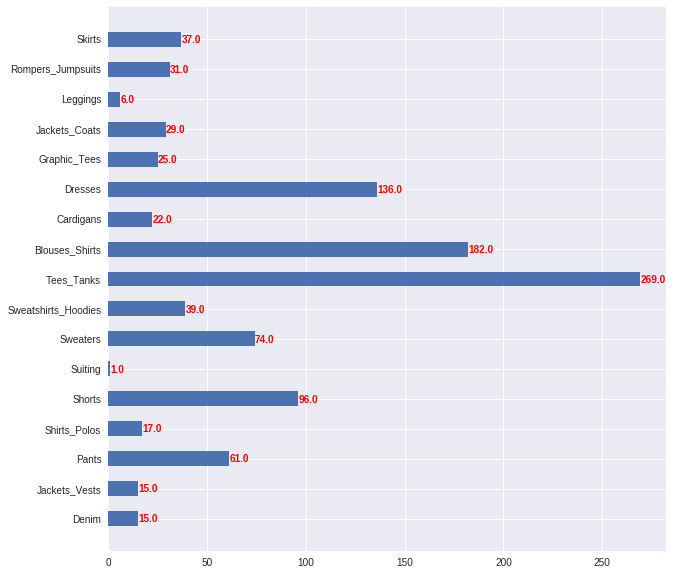

In [0]:
count_style_factor(test_paths)

# Model
## Transfer learning based on VGG16

In [0]:
# Config Model
IMAGE_SIZE = 96
IMAGE_DEPTH = 3
IMAGE_SHAPE = [IMAGE_SIZE, IMAGE_SIZE, IMAGE_DEPTH]
BINARY_GENDER_OUTPUTS = 1
CATEGORICAL_STYLE_OUTPUTS = 17
NUM_LABELS = 18

In [24]:
# Construct Model
# Transfer learning using VGG16
l_input = Input(IMAGE_SHAPE)
vgg = vgg19.VGG19(include_top=False, input_tensor=l_input)
x = Flatten()(vgg.output)
x = Dropout(0.2)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.2)(x)
l_output = Dense(4096, activation='relu')(x)
# x = Dropout(0.2)(x)
# l_output = Dense(128, activation='relu')(x)
# l_output = Dropout(0.2)(x)

gender_output = Dense(BINARY_GENDER_OUTPUTS, activation='sigmoid', name='gender_output')(l_output)
style_output = Dense(CATEGORICAL_STYLE_OUTPUTS, activation='softmax', name='style_output')(l_output)

model = Model(inputs=l_input, outputs=[gender_output, style_output])

for layer in model.layers[:10]:
  layer.trainable = False
  
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 96, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 96, 64)   36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 48, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [0]:
# Check point calllbacks
# Loss on training phase
if not os.path.isdir('Models_Fashion'):
  os.mkdir('Models_Fashion')
  
loss_train_checkpoint_name = 'Models_Fashion/loss-train-weights-improvement-{loss:.4f}.hdf5'

# Loss on val phase
# common loss
loss_val_check_point_name = 'Models_Fashion/loss-test-weights-improvement-{val_loss:.4f}.hdf5'

# specific loss
loss_val_gender_checkpoint_name = 'Models_Fashion/loss-val-gender-weights-improvement-{val_gender_output_loss:.4f}-{val_gender_output_acc:.4f}.hdf5'
loss_val_style_checkpoint_name = 'Models_Fashion/loss-val-style-weights-improvement-{val_style_output_loss:.4f}-{val_style_output_acc:.4f}.hdf5'

#-------------------------------------------------------------------------------#
loss_train_checkpoint = ModelCheckpoint(filepath=loss_train_checkpoint_name, 
                                    monitor='loss', 
                                    verbose=1, 
                                    save_best_only=True)

loss_val_check_point = ModelCheckpoint(filepath=loss_val_check_point_name, 
                                    monitor='val_loss', 
                                    verbose=1, 
                                    save_best_only=True)

loss_val_gender_checkpoint = ModelCheckpoint(filepath=loss_val_gender_checkpoint_name, 
                                    monitor='val_gender_output_loss', 
                                    verbose=1, 
                                    save_best_only=True)

loss_val_style_checkpoint = ModelCheckpoint(filepath=loss_val_style_checkpoint_name, 
                                    monitor='val_style_output_loss', 
                                    verbose=1, 
                                    save_best_only=True)

callback_list = [loss_train_checkpoint, loss_val_check_point, loss_val_gender_checkpoint, loss_val_style_checkpoint]

In [0]:
# Compile
model.compile(optimizer='Adam', 
            loss={'gender_output': 'binary_crossentropy', 
                  'style_output': 'categorical_crossentropy'}, 
            metrics=['accuracy'],
            loss_weights={'gender_output': 1.0, 
                          'style_output': 0})

In [0]:
# Train plot
history = {
    'loss': [],
    'style_output_loss': [],
    'gender_output_loss': [],
    'gender_output_acc':[],
    'style_output_acc': [],
    'val_loss': [],
    'val_gender_output_loss': [],
    'val_style_output_loss': [],
    'val_gender_output_acc': [],
    'val_style_output_acc': []
}

In [0]:
# Preprocessing Images
class DeepFashionDataset():
  def __remove_whitespace__(self, arr):
          result = []
          for item in arr:
              if item != '':
                  result.append(item)

          return result


  def __load_anotation_file__(self, anotation_dir):
      file_path = []
      coordinations = []
      with open(anotation_dir, 'r') as file:
          lines = file.readlines()

          for line in lines[2::]:
              txt_arr = line.split(' ')
              result = self.__remove_whitespace__(txt_arr)
              file_path.append(result[0])
              coordinations.append([result[1], result[2], result[3], result[4]])

      return file_path, coordinations


  def __aligned_crop__(self, img, coordinations):
      x1 = int(coordinations[0])
      y1 = int(coordinations[1])
      x2 = int(coordinations[2])
      y2 = int(coordinations[3])

      width = np.abs(x2 - x1)
      height = np.abs(y2 - y1)

      if width < height:
          print('__aligned_crop__: {}'.format(1))
          center = (x2 + x1)/2
          print('center :', center)
          offset = height/2
          print('offset :', offset)

          x1 = int(center - offset) if int(center - offset) >= 0 else 0
          x2 = int(center + offset)


          cv2.circle(img, (int(center), y1), 2, (0, 255, 255), 2)

      elif width > height:
          print('__aligned_crop__: {}'.format(2))
          center = (y2 + y1)/2
          offset = width/2
          y1 = int(center - offset) if int(center - offset) >= 0 else 0 
          y2 = int(center + offset)

      print(x1)
      print(y1)
      print(x2)
      print(y2)

      return img[y1:y2, x1:x2, :]


  def load_images_with_notations(self, data_dir, anotation_dir, save_image=False, saved_file_path=None):
      file_path, coordinations = self.__load_anotation_file__(anotation_dir)


      for file_name, coord in zip(file_path, coordinations):
          print(coord)
          image_path = os.path.join(data_dir, file_name)
          original_img = cv2.imread(image_path)

          print('image_path: {}'.format(image_path))
          x1 = int(coord[0])
          y1 = int(coord[1])
          x2 = int(coord[2])
          y2 = int(coord[3])
#           cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
          cropped_img  = self.__aligned_crop__(original_img, coord) 

      return cropped_img

# Training

In [0]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'

  def __init__(self, list_IDs, labels=None, batch_size=32, dim=(32, 32), n_channels=1,
               n_classes=10, shuffle=True, training=False):
    
    'Initialization'
    self.dim = dim                     
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.__on_epoch_end()
    self.training = training


  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))


  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)
    return X, y


  def __on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
        np.random.shuffle(self.indexes)
        
        
  def __read_image(self, path):
    img = keras.preprocessing.image.load_img(path)
    img = keras.preprocessing.image.img_to_array(img)
    
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    if self.training == True:
      img = self.__augment_data(img)
      
    img = img/255.0
    img = self.__prewhiten(img)
    return img

  
  def __read_label(self, path):
    label = path.split('/')[-2]
    return label
  
  
  def __prewhiten(self, x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y 
  
  
  def __categorize_labels(self, file_path):
    NUM_LABELS = 18
    STYLES = ['Denim', 'Jackets_Vests', 'Pants', 'Shirts_Polos', 'Shorts', 
              'Suiting', 'Sweaters', 'Sweatshirts_Hoodies', 'Tees_Tanks', 
              'Blouses_Shirts', 'Cardigans', 'Dresses','Graphic_Tees',
              'Jackets_Coats', 'Leggings', 'Rompers_Jumpsuits','Skirts']


    labels = np.zeros((1, NUM_LABELS))  # 0:     gender
                                        # 1-18 : style

    # file_path: /content/img/MEN/Denim/id_00002243/01_1_front.jpg 
    style = file_path.split('/')[-3]
    gender = file_path.split('/')[-4]

    if gender == 'WOMEN':
      labels[0, 0] = 1   # Female
    else:
      labels[0, 0] = 0   # Male

    for idx, style_in_arr in enumerate(STYLES):
      if style == style_in_arr:
        labels[0, idx+1] = 1
    labels = np.asarray(labels).reshape(-1)
    return labels
  

  def __augment_data(self, image):
    """
    if np.random.random() > 0.5:
        images[i] = random_crop(images[i],4)
    """
    if np.random.random() > 0.75:
        image = tf.contrib.keras.preprocessing.image.random_rotation(image, 20, row_axis=0, col_axis=1, channel_axis=2)
    if np.random.random() > 0.75:
        image = tf.contrib.keras.preprocessing.image.random_shear(image, 0.2, row_axis=0, col_axis=1, channel_axis=2)
    if np.random.random() > 0.75:
        image = tf.contrib.keras.preprocessing.image.random_shift(image, 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2)
    if np.random.random() > 0.75:
        image = tf.contrib.keras.preprocessing.image.random_zoom(image, [0.8, 1.2], row_axis=0, col_axis=1, channel_axis=2)
    if np.random.random() > 0.5:
        image = tf.contrib.keras.preprocessing.image.flip_axis(image, axis=1)
    return image


  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size, self.n_classes), dtype=int)
  
#     print(X.shape)
#     print(y.shape)
    
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        X[i,] = self.__read_image(ID)

        # Store class
        y[i] = self.__categorize_labels(ID)

    return X, [y[:, 0], y[:, 1::]]

    

In [14]:
# Split Training and Testing data
# file_path: /content/img/MEN/Denim/id_00002243/01_1_front.jpg 
image_paths = glob.glob('/content/img/*/*/*/*.jpg')
print('Number of Images: {}'.format(len(image_paths)))


Number of Images: 52712


In [15]:
train_paths, test_paths = train_test_split(image_paths, random_state=0, test_size=0.02)
print('Number of train_paths: {}'.format(len(train_paths)))
print('Number of test_paths: {}'.format(len(test_paths)))

Number of train_paths: 51657
Number of test_paths: 1055


In [0]:
train_params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': 10,
          'n_classes': NUM_LABELS,
          'n_channels': IMAGE_DEPTH,
          'shuffle': True,
          'training': False}


val_params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': 10,
          'n_classes': NUM_LABELS,
          'n_channels': IMAGE_DEPTH,
          'shuffle': True,
          'training': False}

# Generators
training_generator = DataGenerator(train_paths, **train_params)
validation_generator = DataGenerator(test_paths, **val_params)

In [34]:
model.fit_generator(training_generator,
                    verbose=1,
                    epochs=50,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=10, 
                    callbacks=callback_list)

Epoch 1/50
 515/5165 [=>............................] - ETA: 13:06 - loss: 2.4115 - gender_output_loss: 2.4115 - style_output_loss: 11.7240 - gender_output_acc: 0.8487 - style_output_acc: 0.2726

1060/5165 [=====>........................] - ETA: 11:23 - loss: 2.3628 - gender_output_loss: 2.3628 - style_output_loss: 11.7206 - gender_output_acc: 0.8518 - style_output_acc: 0.2728

1605/5165 [========>.....................] - ETA: 9:50 - loss: 2.3760 - gender_output_loss: 2.3760 - style_output_loss: 11.7255 - gender_output_acc: 0.8510 - style_output_acc: 0.2725

2153/5165 [===========>..................] - ETA: 8:18 - loss: 2.3436 - gender_output_loss: 2.3436 - style_output_loss: 11.7041 - gender_output_acc: 0.8530 - style_output_acc: 0.2739

2701/5165 [==============>...............] - ETA: 6:47 - loss: 2.3686 - gender_output_loss: 2.3686 - style_output_loss: 11.7028 - gender_output_acc: 0.8514 - style_output_acc: 0.2739

3249/5165 [=================>............] - ETA: 5:16 - loss: 2.3641 - gender_output_loss: 2.3641 - style_output_loss: 11.6939 - gender_output_acc: 0.8517 - style_output_acc: 0.2745

3797/5165 [=====================>........] - ETA: 3:45 - loss: 2.3571 - gender_output_loss: 2.3571 - style_output_loss: 11.6995 - gender_output_acc: 0.8521 - style_output_acc: 0.2741

4345/5165 [========================>.....] - ETA: 2:15 - loss: 2.3765 - gender_output_loss: 2.3765 - style_output_loss: 11.6993 - gender_output_acc: 0.8509 - style_output_acc: 0.2742

4893/5165 [===========================>..] - ETA: 44s - loss: 2.3720 - gender_output_loss: 2.3720 - style_output_loss: 11.7013 - gender_output_acc: 0.8512 - style_output_acc: 0.2740

5165/5165 [==============================] - 858s 166ms/step - loss: 2.3714 - gender_output_loss: 2.3714 - style_output_loss: 11.6912 - gender_output_acc: 0.8512 - style_output_acc: 0.2747 - val_loss: 2.3230 - val_gender_output_loss: 2.3230 - val_style_output_loss: 11.9581 - val_gender_output_acc: 0.8543 - val_style_output_acc: 0.2581

Epoch 00001: loss improved from 14.05644 to 2.37145, saving model to Models_Fashion/loss-train-weights-improvement-2.3714.hdf5

Epoch 00001: val_loss improved from 14.31166 to 2.32303, saving model to Models_Fashion/loss-test-weights-improvement-2.3230.hdf5

Epoch 00001: val_gender_output_loss improved from 2.33822 to 2.32303, saving model to Models_Fashion/loss-val-gender-weights-improvement-2.3230-0.8543.hdf5

Epoch 00001: val_style_output_loss improved from 11.97344 to 11.95809, saving model to Models_Fashion/loss-val-style-weights-improvement-11.9581-0.2581.hdf5
Epoch 2/50
  35/5165 [..............................] - ETA: 14:12 - loss: 2.1864 - gende

 580/5165 [==>...........................] - ETA: 12:36 - loss: 2.3611 - gender_output_loss: 2.3611 - style_output_loss: 11.7051 - gender_output_acc: 0.8519 - style_output_acc: 0.2738

1125/5165 [=====>........................] - ETA: 11:06 - loss: 2.3751 - gender_output_loss: 2.3751 - style_output_loss: 11.6795 - gender_output_acc: 0.8510 - style_output_acc: 0.2754

1646/5165 [========>.....................] - ETA: 9:40 - loss: 2.3420 - gender_output_loss: 2.3420 - style_output_loss: 11.7008 - gender_output_acc: 0.8531 - style_output_acc: 0.2741

Process ForkPoolWorker-108:
Process ForkPoolWorker-100:
Process ForkPoolWorker-97:
Process ForkPoolWorker-95:
Process ForkPoolWorker-96:
Traceback (most recent call last):
Process ForkPoolWorker-105:
Process ForkPoolWorker-101:
Process ForkPoolWorker-110:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-106:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 347, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task 

KeyboardInterrupt: ignored

In [31]:
!top

=top - 03:39:42 up  2:10,  0 users,  load average: 0.30, 0.21, 0.75
Tasks:  18 total,   1 running,  17 sleeping,   0 stopped,   0 zombie
%Cpu(s): 47.0 us,  4.6 sy,  0.0 ni, 47.9 id,  0.4 wa,  0.0 hi,  0.1 si,  0.0 st
KiB Mem : 13341832 total,   221352 free,  4865912 used,  8254568 buff/cache
KiB Swap:        0 total,        0 free,        0 used.  7562004 avail Mem 

  PID USER      PR  NI    VIRT    RES    SHR S  %CPU %MEM     TIME+ COMMAND     
    1 root      20   0   39148   6520   5144 S   0.0  0.0   0:00.09 run.sh      
   69 root      20   0  688536  49088  21772 S   0.0  0.4   0:05.43 node        
   79 root      20   0  740808  77376  22852 S   0.0  0.6   0:49.03 node        
   89 root      20   0  188044  61784  12400 S   0.0  0.5   0:38.27 jupyter-no+ 
 1113 root      20   0 39.314g 1.398g  76944 S   0.0 11.0   0:00.00 python3     
 1114 root      20   0 39.314g 1.398g  76944 S   0.0 11.0   0:00.00 python3     
 1115 root      20   0 39.314g 1.398g  76944 S   0.0 11.0   0:

top - 03:40:12 up  2:11,  0 users,  load average: 0.18, 0.19, 0.72

%Cpu(s):  1.5 us,  1.3 sy,  0.0 ni, 97.0 id,  0.2 wa,  0.0 hi,  0.0 si,  0.0 st
KiB Mem : 13341832 total,   217516 free,  4869332 used,  8254984 buff/cache
KiB Swap:        0 total,        0 free,        0 used.  7558604 avail Mem 


 1200 root      20   0 38.870g 1.428g 552060 S   3.7 11.2   0:19.61 python3     
 1160 root      20   0 39.739g 2.163g 423656 S   1.3 17.0   1:00.88 python3     
   69 root      20   0  688536  49088  21772 S   0.3  0.4   0:05.45 node        
   79 root      20   0  740808  78300  22852 S   0.3  0.6   0:49.09 node        
   89 root      20   0  188044  61880  12400 S   0.3  0.5   0:38.31 jupyter-no+ 
    1 root      20   0   39148   6520   5144 S   0.0  0.0   0:00.09 run.sh      










top - 03:40:15 up  2:11,  0 users,  load average: 0.17, 0.18, 0.72

%Cpu(s):  1.5 us,  1.5 sy,  0.0 ni, 96.8 id,  0.0 wa,  0.0 hi,  0.2 si,  0.0 st
KiB Mem : 13341832 total,   217736 free,  4869092 used

In [0]:
!kill -9 1200

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

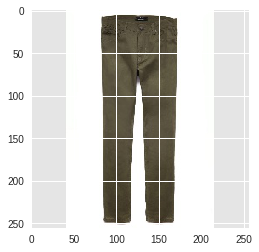

In [22]:
I = plt.imread('/content/img/MEN/Denim/id_00000089/08_6_flat.jpg')
plt.imshow(I)